# ColQwen2: One model for your whole RAG pipeline with adapter hot-swapping 🔥

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/tonywu71/colpali-cookbooks/blob/main/examples/run_e2e_rag_colqwen2_with_adapter_hot_swapping.ipynb)
[![GitHub](https://img.shields.io/badge/ColPali_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/tonywu71/colpali-cookbooks)
[![arXiv](https://img.shields.io/badge/arXiv-2407.01449-b31b1b.svg?style=for-the-badge)](https://arxiv.org/abs/2407.01449)
[![Hugging Face](https://img.shields.io/badge/Vidore-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/vidore)
[![X](https://img.shields.io/badge/Thread-%23000000?style=for-the-badge&logo=X&logoColor=white)](https://x.com/tonywu_71/status/1809183824464560138)

## Introduction

With our new model [*ColQwen2*](https://x.com/ManuelFaysse/status/1839657285053788483), we propose to leverage VLMs to construct efficient multi-vector embeddings in the visual space for document retrieval. By feeding the ViT output patches from [Qwen2-VL](https://doi.org/10.48550/arXiv.2409.12191) to a linear projection, we create a multi-vector representation of documents. We train the model to maximize the similarity between these document embeddings and the query embeddings, following the ColBERT method.

Using ColQwen2 removes the need for potentially complex and brittle layout recognition and OCR pipelines with a single model that can take into account both the textual and visual content (layout, charts, ...) of a document.

Because ColQwen2 was trained with [LoRA](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora), you can easily use adapter hot-swapping to switch between:
1. Using the pre-trained adapter for creating the document embeddings used for retrieval
2. Unload the adapter and use the backbone VLM for image-grounded generation.

![E2E RAG example](https://github.com/tonywu71/colpali-cookbooks/blob/main/assets/rag/e2e_rag_with_colqwen2_diagram.jpeg?raw=true)

With this method, you can use a single model for your whole RAG pipeline, hence saving the need of having multiple models that take up a lot of VRAM! 😍

## Hardware Requirements

You can run it on Google Colab (using the free-tier T4 GPU) or locally (tested on a M2 Pro Mac).

## Important ⚠️
The Qwen2-VL model used in ColQwen2 is the [`Qwen/Qwen2-VL-2B-Instruct`](https://huggingface.co/Qwen/Qwen2-VL-2B-Instruct) checkpoint, which is relatively small compared to other VLMs available at the time of writing. Based on my experiments and findings from the [Qwen2-VL paper](https://doi.org/10.48550/arXiv.2409.12191), the 2B version performs well for text-heavy documents (e.g., DocVQA) but falls short compared to larger checkpoints when it comes to understanding complex charts (e.g., ChartQA and InfoVQA).

| Benchmark   | Qwen2-VL-72B | Qwen2-VL-7B | Qwen2-VL-2B (used in ColQwen2) |
|-------------|--------------|-------------|--------------------------------|
| DocVQA      | **96.5**     | 94.5        | 90.1                           |
| ChartQA     | **88.3**     | 83.0        | 73.5                           |
| InfoVQA     | **84.5**     | 76.5        | 65.5                           |

Thus, if you need stronger reasoning capabilities for your RAG, I recommend using using ColQwen2 for retrieval and a larger VLM for generation, e.g. [`Qwen/Qwen2-VL-72B-Instruct`](https://huggingface.co/Qwen/Qwen2-VL-72B-Instruct) or [`mistralai/Pixtral-12B-2409`](https://huggingface.co/mistralai/Pixtral-12B-2409). While this approach uses more VRAM, separate models offer more flexibility for the generation part.

## Imports

This notebook leverages [`colpali-engine`](https://github.com/illuin-tech/colpali), the official implementation of ColPali and ColQwen2. This package also contains the training code (processor, collator, trainer...) for fine-tuning these models on your own dataset.

In [1]:
!pip install -q -U "colpali-engine>=0.3.1,<0.4.0" requests

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.9 MB/s eta 0:00:00


In [2]:
from io import BytesIO
from typing import Any, List, cast

import requests
import torch
from colpali_engine.models import ColQwen2, ColQwen2Processor
from colpali_engine.utils.torch_utils import get_torch_device
from IPython.display import display
from peft import LoraConfig
from PIL import Image
from transformers.models.qwen2_vl import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

## A few custom utils

In [3]:
def load_image_from_url(url: str) -> Image.Image:
    """
    Load a PIL image from a valid URL.
    """
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    scaled_image = image.resize((new_width, new_height))

    return scaled_image

## The `ColQwen2ForRAG` class

To simplify the usage of ColQwen2 for RAG, I have provided a `ColQwen2ForRAG` class that:
- wraps the original `ColQwen2` model
- hides the complexity behind adapter handling (the current version of PEFT is not always straightforward to use)
- provides a simple API to switch between the retrieval and the generation modes.

In [4]:
class ColQwen2ForRAG(ColQwen2):
    """
    ColQwen2 model implementation that can be used both for retrieval and generation.
    Allows switching between retrieval and generation modes.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._is_retrieval_enabled = True

    def forward(self, *args, **kwargs) -> Any:
        """
        Forward pass that calls either Qwen2VLForConditionalGeneration.forward for generation
        or ColQwen2.forward for retrieval based on the current mode.
        """
        if self.is_retrieval_enabled:
            return ColQwen2.forward(self, *args, **kwargs)
        else:
            return Qwen2VLForConditionalGeneration.forward(self, *args, **kwargs)

    def generate(self, *args, **kwargs):
        """
        Generate text using Qwen2VLForConditionalGeneration.generate.
        """
        if not self.is_generation_enabled:
            raise ValueError(
                "Set the model to generation mode by calling `enable_generation()` before calling `generate()`."
            )
        return super().generate(*args, **kwargs)

    @property
    def is_retrieval_enabled(self) -> bool:
        return self._is_retrieval_enabled

    @property
    def is_generation_enabled(self) -> bool:
        return not self.is_retrieval_enabled

    def enable_retrieval(self) -> None:
        """
        Switch to retrieval mode.
        """
        self.enable_adapters()
        self._is_retrieval_enabled = True

    def enable_generation(self) -> None:
        """
        Switch to generation mode.
        """
        self.disable_adapters()
        self._is_retrieval_enabled = False

## Load ColQwen2

Click on the following link to open the model card for [`vidore/colqwen2-v1.0`](https://huggingface.co/vidore/colqwen2-v1.0).

In [5]:
model_name = "vidore/colqwen2-v1.0"
device = get_torch_device("auto")

print(f"Using device: {device}")

# Get the LoRA config from the pretrained retrieval model
lora_config = LoraConfig.from_pretrained(model_name)

# Load the processors
processor_retrieval = cast(ColQwen2Processor, ColQwen2Processor.from_pretrained(model_name))
processor_generation = cast(Qwen2VLProcessor, Qwen2VLProcessor.from_pretrained(lora_config.base_model_name_or_path))

# Load the model with the loaded pre-trained adapter for retrieval
model = cast(
    ColQwen2ForRAG,
    ColQwen2ForRAG.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
)

Using device: cuda:0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

Run the following cell to load the default query and image inputs. If you want to use your own image/query, upload your image in the Google Colab environment, then replace the following variable values with your own.

The images represent your RAG corpus. For simplicity, we will use only 2 images in this example and ask the model to retrieve the most relevant one for the input query.

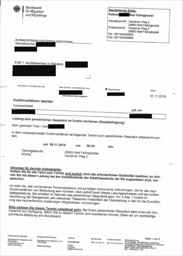

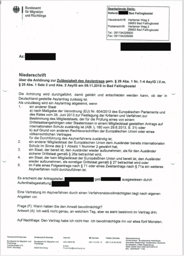

In [22]:
# Inputs
query = "Was muss bei beim Dublinverfahren mitgebracht werden?"

images: List[Image.Image] = [
    load_image_from_url(
        "https://www.fluechtlinge-willkommen-in-duesseldorf.de/fileadmin/public/Redaktion/Bilder/Content/Asyl/asyl_leitfaden.6.muster-ladung-zur-persoenlichen-anhoerung.PNG?raw=true"
    ),
    load_image_from_url(
        "https://www.fluechtlinge-willkommen-in-duesseldorf.de/fileadmin/public/Redaktion/Bilder/Content/Asyl/asyl_leitfaden.7.muster-protokoll-ueber-persoenliche-anhoerung.PNG?raw=true"
    ),
]
# NOTE: Because ColQWen2 uses dynamic resolution, we will scale down the images to prevent VRAM overload and faster
# inference times for both indexing and generation. From my experiments, a scale of 512 pixels is a good default for
# document tasks. Feel free to experiment with higher resolutions, especially if the text on your document is small.
images = [scale_image(image, new_height=512) for image in images]

for image in images:
    display(scale_image(image, new_height=256))

## Part 1 of RAG: Retrieval

This is the retrieval part of the RAG. In this example, we only keep the top-1 result for demonstration purposes.

In practice, using more results (e.g., top-5) can improve the quality of the final answer.

Image retrieved for the following query: `Wann ist der persönliche Termin zum Dublinverfahren?`


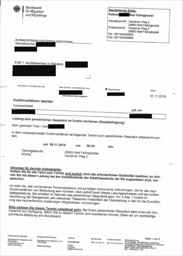

In [25]:
query = "Wann ist der persönliche Termin zum Dublinverfahren?"
# Process the inputs
batch_images = processor_retrieval.process_images(images).to(model.device)
batch_queries = processor_retrieval.process_queries([query]).to(model.device)

# Forward pass
model.enable_retrieval()

with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    query_embeddings = model.forward(**batch_queries)

# Calculate the similarity scores
scores = processor_retrieval.score_multi_vector(query_embeddings, image_embeddings)

# Get the top-1 page image
retrieved_image_index = scores.argmax().item()
retrieved_image = images[retrieved_image_index]

print(f"Image retrieved for the following query: `{query}`")
display(scale_image(retrieved_image, new_height=256))

## Part 2 of RAG: Augmented Generation

Now comes the generation part of the RAG. Using the retrieved image from the retrieval part, we will disable the retrieval adapter in ColQwen2 to use its Qwen2-VL VLM backbone to generate the answer based on both the query and the retrieved image.

In [26]:
# Preprocess the inputs
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": f"Answer the following question using the input image: {query}",
            },
        ],
    }
]
text_prompt = processor_generation.apply_chat_template(conversation, add_generation_prompt=True)
inputs_generation = processor_generation(
    text=[text_prompt],
    images=[image],
    padding=True,
    return_tensors="pt",
).to(device)

# Generate the RAG response
model.enable_generation()
output_ids = model.generate(**inputs_generation, max_new_tokens=128)

# Ensure that only the newly generated token IDs are retained from output_ids
generated_ids = [output_ids[len(input_ids) :] for input_ids, output_ids in zip(inputs_generation.input_ids, output_ids)]

# Decode the RAG response
output_text = processor_generation.batch_decode(
    generated_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True,
)

print(output_text)

['Der persönliche Termin zum Dublinverfahren ist am 29. Juni 2013.']


If you look closely at the input image, you will see that the model has correctly answered the user query! 🙌🏼

Image retrieved for the following query: `Wann findet der Termin zum Dublinverfahren mit Angabe von 'Datum' '_' um 'Uhrzeit' '_' statt, und wo 'Dienstgebäude:' '_', 'Straße:' '_' )?`


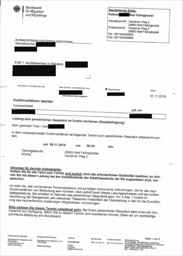

['The Dublinverfahren findet am 29.06.2018 um 10:00 Uhr statt. Es findet im Dienstgebäude Harderer Weg 2, Bad Fallingbostel statt.']


In [39]:
query = "Wann findet der Termin zum Dublinverfahren mit Angabe von 'Datum' '_' um 'Uhrzeit' '_' statt, und wo 'Dienstgebäude:' '_', 'Straße:' '_' )?"
# Process the inputs
batch_images = processor_retrieval.process_images(images).to(model.device)
batch_queries = processor_retrieval.process_queries([query]).to(model.device)

# Forward pass
model.enable_retrieval()

with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    query_embeddings = model.forward(**batch_queries)

# Calculate the similarity scores
scores = processor_retrieval.score_multi_vector(query_embeddings, image_embeddings)

# Get the top-1 page image
retrieved_image_index = scores.argmax().item()
retrieved_image = images[retrieved_image_index]

print(f"Image retrieved for the following query: `{query}`")
display(scale_image(retrieved_image, new_height=256))


# Preprocess the inputs
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": f"Answer the following question using the input image: {query}",
            },
        ],
    }
]
text_prompt = processor_generation.apply_chat_template(conversation, add_generation_prompt=True)
inputs_generation = processor_generation(
    text=[text_prompt],
    images=[image],
    padding=True,
    return_tensors="pt",
).to(device)

# Generate the RAG response
model.enable_generation()
output_ids = model.generate(**inputs_generation, max_new_tokens=128)

# Ensure that only the newly generated token IDs are retained from output_ids
generated_ids = [output_ids[len(input_ids) :] for input_ids, output_ids in zip(inputs_generation.input_ids, output_ids)]

# Decode the RAG response
output_text = processor_generation.batch_decode(
    generated_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True,
)

print(output_text)

In [79]:
query = "Wer ist der Absender als 'Hausanschrift' und Straße '_'  und Zip Code / Ort '_', und wie lautet die Telefonnummer '_', und Faxnummer '_')?"

# Preprocess the inputs
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": f"Answer the following question using the input image: {query}",
            },
        ],
    }
]
text_prompt = processor_generation.apply_chat_template(conversation, add_generation_prompt=True)
inputs_generation = processor_generation(
    text=[text_prompt],
    images=[image],
    padding=True,
    return_tensors="pt",
).to(device)

# Generate the RAG response
model.enable_generation()
output_ids = model.generate(**inputs_generation, max_new_tokens=128)

# Ensure that only the newly generated token IDs are retained from output_ids
generated_ids = [output_ids[len(input_ids) :] for input_ids, output_ids in zip(inputs_generation.input_ids, output_ids)]

# Decode the RAG response
output_text = processor_generation.batch_decode(
    generated_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True,
)

print(output_text)

['Der Absender ist als Hausanschrift "Hartneger Weg 2" und Straße "Bad Fallingbostel" und hat einen Postanschrift "Hartneger Weg 2" und einen Telefonnummer "09114422000" und Faxnummer "09114422009".']


['Die Niederschrift handelt um die Anhörung zur Zulässigkeit des Asylantrags gemäß § 29 Abs. 1 Nr. 1-4 AsylG i.V.m. § 25 Abs. 1 Satz 2 und Abs. 2 AsylG am 09.11.2018 in Bad Fallingbostel.']


**Scan-Quality Check:** Nun ein Versuch die im Scan die nicht lesbaren Informationen wie Bankverbindung auszulesen.

In [72]:
query = "Welche Bankverbindung mit Kontoinhaber ist in der Fußnote angegeben und wie lautet dessen IBAN '_' bzw. dessen BIC '_'?"

# Preprocess the inputs
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": f"Please return any text independet of the quality. Answer the following question using the input image: {query}",
            },
        ],
    }
]
text_prompt = processor_generation.apply_chat_template(conversation, add_generation_prompt=True)
inputs_generation = processor_generation(
    text=[text_prompt],
    images=[image],
    padding=True,
    return_tensors="pt",
).to(device)

# Generate the RAG response
model.enable_generation()
output_ids = model.generate(**inputs_generation, max_new_tokens=256)

# Ensure that only the newly generated token IDs are retained from output_ids
generated_ids = [output_ids[len(input_ids) :] for input_ids, output_ids in zip(inputs_generation.input_ids, output_ids)]

# Decode the RAG response
output_text = processor_generation.batch_decode(
    generated_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True,
)

print(output_text)

['Die angegebene Bankverbindung ist die Deutsche Bank AG, und ihr IBAN lautet DE01 DEUB 00000000000000000000.']


## 🙋🏻 Reminder
If you want to re-run retrieval after this cell, make sure to use `model.enable_retrieval()` before `model.forward(...)`!

## Additional notes

- Try to rerun the previous cells but with the following query instead: `"Which hour of the day had the highest overall electricity generation in 2019?"`. You will see that ColQwen2 is capable of retrieving the correct page, but you should get an hallucinated answer for the generation part. As explained in one of the first sections, this is because [Qwen2-VL-2B](https://huggingface.co/Qwen/Qwen2-VL-2B-Instruct) has only a "small" number of parameters, which limits its chart understanding compared to its larger [12B](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct) and [72B](https://huggingface.co/Qwen/Qwen2-VL-72B-Instruct) counterparts.
- While our [ColPali](https://huggingface.co/vidore/colpali-v1.3) model was also trained using a LoRA adapter, I do not recommend using it for E2E RAG as the PaliGemma VLM backbone can only take one image input at a time. Consequently, your RAG pipeline will only be capble of using a top-1 page context for generation, which will likely lead to suboptimal results.

['Die Niederschrift handelt um die Anhörung zur Zulässigkeit des Asylantrags gemäß § 29 Abs. 1 Nr. 1-4 AsylG i.V.m. § 25 Abs. 1 Satz 2 und Abs. 2 AsylG am 09.11.2018 in Bad Fallingbostel.']
